In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Разархивируем датасет

In [ ]:
!unzip "/content/drive/MyDrive/10 Monkey Species.zip"

Archive:  /content/drive/MyDrive/10 Monkey Species.zip
  inflating: monkey_labels.txt       
  inflating: training/training/n0/n0018.jpg  
  inflating: training/training/n0/n0019.jpg  
  inflating: training/training/n0/n0020.jpg  
  inflating: training/training/n0/n0021.jpg  
  inflating: training/training/n0/n0022.jpg  
  inflating: training/training/n0/n0023.jpg  
  inflating: training/training/n0/n0024.jpg  
  inflating: training/training/n0/n0025.jpg  
  inflating: training/training/n0/n0026.jpg  
  inflating: training/training/n0/n0027.jpg  
  inflating: training/training/n0/n0028.jpg  
  inflating: training/training/n0/n0029.jpg  
  inflating: training/training/n0/n0030.jpg  
  inflating: training/training/n0/n0031.jpg  
  inflating: training/training/n0/n0032.jpg  
  inflating: training/training/n0/n0033.jpg  
  inflating: training/training/n0/n0034.jpg  
  inflating: training/training/n0/n0035.jpg  
  inflating: training/training/n0/n0036.jpg  
  inflating: training/training/n0

После открытия папки мы увидели 2 папки с фотографиями "training" и "validation", в каждой из которых по 10 папок с фотографиями обезьян разных видов. Папка "training" для обучения модели и папка "validation" для теста, соответственно.
Перед нами стоит задача обучить модель классификации вида обезьян по фотографии.

Создадим датафрейм для нагляности данных и удобства выполнения

In [ ]:
import pandas as pd
data = pd.read_csv("/content/monkey_labels.txt")
data

,Label,Latin Name,Common Name,Train Images,Validation Images
0,n0,alouatta_palliata\t,mantled_howler,131,26
1,n1,erythrocebus_patas\t,patas_monkey,139,28
2,n2,cacajao_calvus\t,bald_uakari,137,27
3,n3,macaca_fuscata\t,japanese_macaque,152,30
4,n4,cebuella_pygmea\t,pygmy_marmoset,131,26
5,n5,cebus_capucinus\t,white_headed_capuchin,141,28
6,n6,mico_argentatus\t,silvery_marmoset,132,26
7,n7,saimiri_sciureus\t,common_squirrel_monkey,142,28
8,n8,aotus_nigriceps\t,black_headed_night_monkey,133,27
9,n9,trachypithecus_johnii,nilgiri_langur,132,26


Приводим все названия столбцов к удобному виду, убирая лишние пробелы

In [ ]:
data.columns = data.columns.str.strip()

In [ ]:
data.columns.tolist()

['Label', 'Latin Name', 'Common Name', 'Train Images', 'Validation Images']

In [ ]:
data

,Label,Latin Name,Common Name,Train Images,Validation Images
0,n0,alouatta_palliata\t,mantled_howler,131,26
1,n1,erythrocebus_patas\t,patas_monkey,139,28
2,n2,cacajao_calvus\t,bald_uakari,137,27
3,n3,macaca_fuscata\t,japanese_macaque,152,30
4,n4,cebuella_pygmea\t,pygmy_marmoset,131,26
5,n5,cebus_capucinus\t,white_headed_capuchin,141,28
6,n6,mico_argentatus\t,silvery_marmoset,132,26
7,n7,saimiri_sciureus\t,common_squirrel_monkey,142,28
8,n8,aotus_nigriceps\t,black_headed_night_monkey,133,27
9,n9,trachypithecus_johnii,nilgiri_langur,132,26


Теперь проанализируем данные. Для этого импортируем библиотеку os для работы с папками. Найдём в данном случае все пропуски в данных или неправильно отформатированные файлы. Нас в данном случае интересуют только картинки обезьян, так как именно по ним и будет проводиться дальнейшее обучение модели. Поэтому все файлы с расширением не jpg, jpeg или png считаем неправильными и в дальнейшем удалим.

In [ ]:
import os #библиотека для работы с папками
folder_dir="/content/training/training" #директория (расположение) тренировочной выборки

 # Удаляем пробелы из значений всех строк
data = data.applymap(lambda x: x.strip() if isinstance(x, str) else x)

# Создадим словари для хранения лейблов и их значений.
folder_counts = {label: 0 for label in data['Label'].unique()} # Словарь для подсчёта сколько в каждом лейбле картинок
difference = {label: 0 for label in data['Label'].unique()} #Словарь для отличиий между указаным числом в txt файле и насчитанным действительно
neg = {label: 0 for label in data['Label'].unique()} #Словарь для подсчёта сколько файлов неподходящего расширения
# Проходим по папкам в директории folder_dir
for label in folder_counts.keys(): #словари в которых ключ это класс обезьяны а значение это фотка??
  counter_pos = 0 #счетчик
  counter_neg = 0
  folder_path = os.path.join(folder_dir, label) #путь

# Считаем файлы изображений
  for file in os.listdir(folder_path):
    if file.lower().endswith(('jpg', 'jpeg','png')):
      counter_pos+=1
    else:
      counter_neg+=1
  folder_counts[label] = counter_pos
  diff = data.loc[data['Label'] == label, 'Train Images'].values[0] - counter_pos
  difference[label] = diff
  neg[label] = counter_neg

if 'Common Namel' in data.columns:
    data = data.drop(columns=['Common Namel'])

data['Image_count'] = data['Label'].map(folder_counts)
data['Difference'] = data['Label'].map(difference)
data['Not supported type'] = data['Label'].map(neg)

<ipython-input-7-1dc041f65465>:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data = data.applymap(lambda x: x.strip() if isinstance(x, str) else x)


In [ ]:
folder_counts

{'n0': 105,
 'n1': 111,
 'n2': 110,
 'n3': 122,
 'n4': 105,
 'n5': 113,
 'n6': 106,
 'n7': 114,
 'n8': 106,
 'n9': 106}

In [ ]:
data

,Label,Latin Name,Common Name,Train Images,Validation Images,Image_count,Difference,Not supported type
0,n0,alouatta_palliata,mantled_howler,131,26,105,26,0
1,n1,erythrocebus_patas,patas_monkey,139,28,111,28,0
2,n2,cacajao_calvus,bald_uakari,137,27,110,27,0
3,n3,macaca_fuscata,japanese_macaque,152,30,122,30,0
4,n4,cebuella_pygmea,pygmy_marmoset,131,26,105,26,0
5,n5,cebus_capucinus,white_headed_capuchin,141,28,113,28,0
6,n6,mico_argentatus,silvery_marmoset,132,26,106,26,0
7,n7,saimiri_sciureus,common_squirrel_monkey,142,28,114,28,0
8,n8,aotus_nigriceps,black_headed_night_monkey,133,27,106,27,0
9,n9,trachypithecus_johnii,nilgiri_langur,132,26,106,26,0


Посмотрим на распределение обезьян по их названиям. Удобнее всего использовать bar chart из библиотеки seaborn.

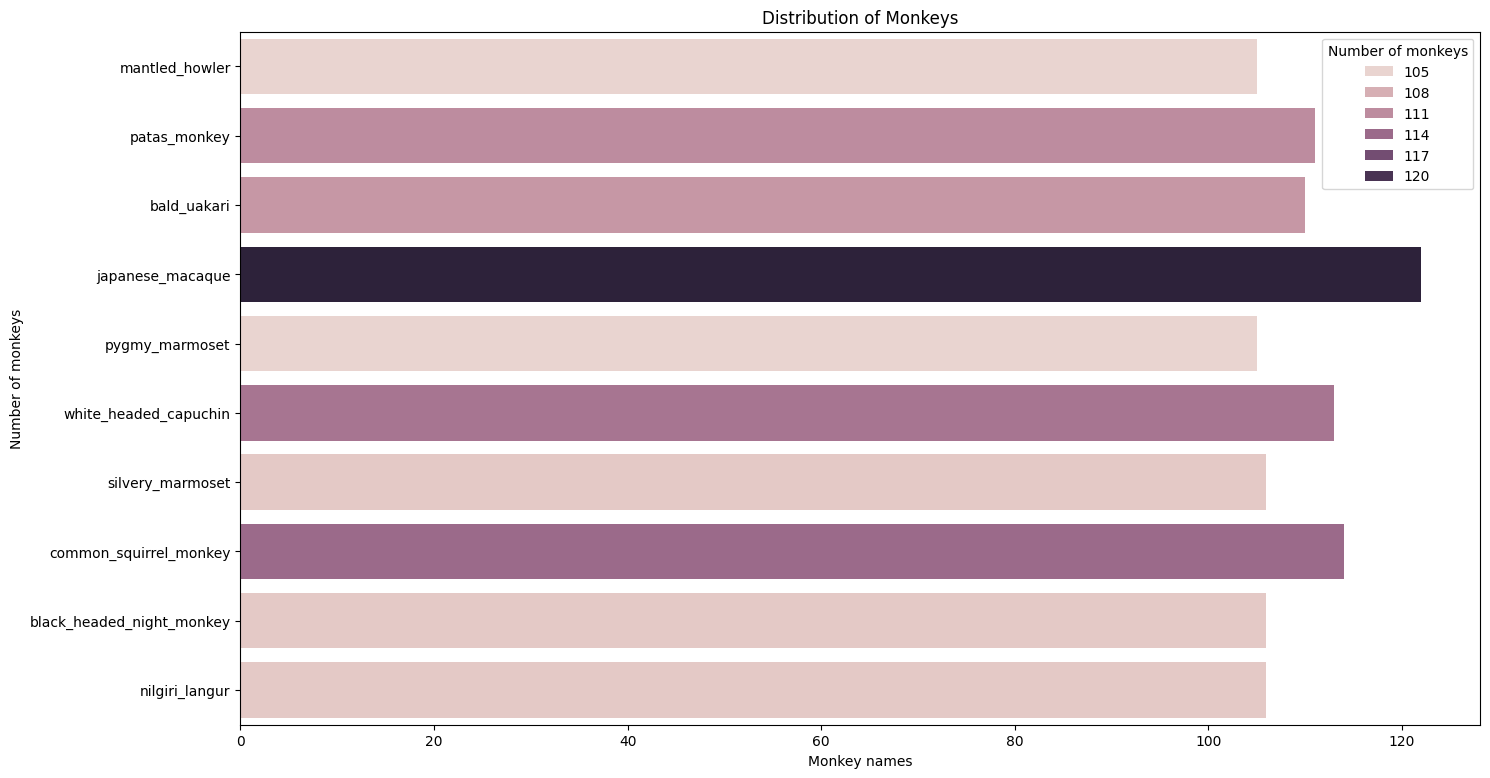

Mean number of monkeys per group is 109.8
Maximum number of monkeys is in the group japanese_macaque with the number of 122 monkeys
Minimum number of monkeys is in the group mantled_howler with the number of 105 monkeys


In [ ]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (16,9))
sns.barplot(data=data, x = 'Image_count', y = 'Common Name', hue = 'Image_count')
plt.title('Distribution of Monkeys')
plt.xlabel('Monkey names')
plt.ylabel('Number of monkeys')
plt.legend(title = 'Number of monkeys')
plt.show()

monkey_mean = np.mean(data['Image_count'])
monkey_max = np.max(data['Image_count'])
monkey_min = np.min(data['Image_count'])

monkey_max_group = data[data['Image_count']==monkey_max]['Common Name'].values[0]
monkey_min_group = data[data['Image_count']==monkey_min]['Common Name'].values[0]

print(f"Mean number of monkeys per group is {monkey_mean}\nMaximum number of monkeys is in the group {monkey_max_group} with the number of {monkey_max} monkeys\nMinimum number of monkeys is in the group {monkey_min_group} with the number of {monkey_min} monkeys")

Видим что количество обезьян для обучения модели везде примерно одинаковое, где-то на парочку больше, где-то меньше придерживаясь среднего значения 109.8. Максимальное число обезьян в группе japanise macaque с числом обезьян 122. Наименьшее количество обезьян в группе mantled howler где их всего 105.

Следующим этапом подготовки и проверки наших данных является кластеризация. Этот метод позволит нам понять, разбиваются ли наши изображения на осмысленные группы и, при наличии, убрать неподходящие для обучения файлы.

Теперь приступим к обучению модели. Так как нам нужно обучить модель классифицировать разные виды обезьян, то будем использовать соответствующие модели для данной задачи. Сначала выполним логистическую регрессию, которая является простейшей моделью. Однако перед обучением модели выполним аугментацию картинок, так как в данном нам датасете их мало.



In [ ]:

from PIL import Image
import torch
from torchvision.transforms import v2
import os
import shutil

#Модуль для аугментации:

transforms = v2.Compose([
    v2.ToImage(),
    v2.RandomResizedCrop(size=(64, 64), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),  # Случайное горизонтальное отражение
    v2.RandomVerticalFlip(p=0.2),  # Случайное вертикальное отражение
    v2.RandomRotation(degrees=30),  # Случайный поворот на ±30°
    v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Изменение цветовых параметров
    v2.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Случайное смещение
    v2.ToDtype(torch.float32, scale=True),
])
folder_dir = "/content/training/training"
output_dir = "/content/training/training/augmented_images"
os.makedirs(output_dir, exist_ok = True)

#Опустошение папки в которую сохраняются картинки
#(сделано потому что при подборке количества картинок аугментированных надо полностью заново запускать ячейку и, дабы не перезаполнить папку, её опустошаем сначала)
folder_path = output_dir
if os.path.exists(folder_path):
    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)

        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print(f"Failed to delete {file_path}. Reason: {e}")
else:
    print(f"Folder {folder_path} does not exist.")


num_aug = 5 #Количество доп картинок(то есть для каждой картинки создается 5 её копий с разными аугментациями)


#Проходимся по всему датасету и сохраняем изменённые картинки в папку augmented_images
for folder in os.listdir(folder_dir):
  type_folder = os.path.join(folder_dir,folder)
  if not os.path.isdir(type_folder):
    continue
  save_folder_path = os.path.join(output_dir, f'aug_{folder}')
  os.makedirs(save_folder_path, exist_ok = True)
  for image in os.listdir(type_folder):
    image_path = os.path.join(type_folder,image)
    if not os.path.isfile(image_path):
      continue
    try:
      img = Image.open(image_path).convert("RGB")
      save_orig_image_path = os.path.join(save_folder_path, f'aug_{image}')
      img.save(save_orig_image_path)
      #Создание аугментированных картинок
      for i in range(num_aug):
        augmented_image = transforms(img)
        save_image_path = os.path.join(save_folder_path, f'aug_{i}_{image}')
        augmented_image = v2.ToPILImage()(augmented_image)
        augmented_image.save(save_image_path)
    except Exception as e:
      print(f' type of error {e}')



 type of error unknown file extension: 


Теперь сама логистическая регрессия. Сначала создаем наши тренировочные данные, то есть преобразуем наши картинки обезьян в числовые данные - векторы.

In [ ]:
def preprocess_images(image_path, size = (64,64)):
  img = Image.open(image_path).convert("RGB").resize(size)
  img_arr = np.array(img, dtype = np.float32)
  return img_arr.flatten()

In [ ]:
from PIL import Image
import numpy as np
import os

x_train = [] #Создаем пустой массив в котором будут матрицы для обучения модели
y_train = [] #Массив с метками для каждой картинки (какой класс) в обучающей выборке

augm_dir = "/content/training/training/augmented_images"

for folder in os.listdir(augm_dir):
  folder_path = os.path.join(augm_dir, folder)
  if not os.path.isdir(folder_path):
    continue
  for image in os.listdir(folder_path):
    image_path = os.path.join(folder_path, image)
    pic = preprocess_images(image_path)
    x_train.append(pic)
    y_train.append(folder)

x_train = np.array(x_train)
y_train = np.array(y_train)

In [ ]:
x_train.shape

(6582, 12288)

Аналогично создадим тестовые данные

In [ ]:
from PIL import Image
import numpy as np
import os


x_test = [] #Создаем пустой массив в котором будут матрицы для проверки модели
y_test = [] #Массив с метками для каждой картинки (какой класс) в тестовой выборке

val_dir = "/content/validation/validation"

for folder in os.listdir(val_dir):
  folder_path = os.path.join(val_dir, folder)
  if not os.path.isdir(folder_path):
    continue
  for image in os.listdir(folder_path):
    image_path = os.path.join(folder_path, image)
    pic = preprocess_images(image_path)
    x_test.append(pic)
    name = "aug_" + folder
    y_test.append(name)

x_test = np.array(x_test)
y_test = np.array(y_test)

In [ ]:
x_test

array([[  7.,   8.,   8., ..., 154., 145.,  76.],
       [ 19.,  19.,   9., ...,  63.,  35.,  16.],
       [102.,  97., 104., ..., 215., 186., 126.],
       ...,
       [149., 162.,  16., ..., 241., 245., 249.],
       [114., 132., 125., ..., 133., 139., 117.],
       [ 91.,  98., 104., ...,  59.,  51.,  40.]], dtype=float32)

Нормируем наши данные, чтобы они варьировались в диапозоне от 0 до 1. Также преобразуем наши целевые переменные так, чтобы они являлись численным. То есть вместо названий aug_0 и тд будут цифры от 0 до 9.

In [ ]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

scaler = MinMaxScaler()
x_tr_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

label_encoder = LabelEncoder()
y_tr_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)


x_tr_scaled

array([[0.01960784, 0.        , 0.0627451 , ..., 0.01176471, 0.        ,
        0.        ],
       [0.00392157, 0.        , 0.05882353, ..., 0.0509804 , 0.04313726,
        0.0627451 ],
       [0.21568629, 0.40784317, 0.14117648, ..., 0.17254902, 0.18039216,
        0.13333334],
       ...,
       [0.01568628, 0.01960784, 0.02745098, ..., 0.        , 0.01176471,
        0.        ],
       [0.04313726, 0.        , 0.05490196, ..., 0.627451  , 0.9843138 ,
        0.7607844 ],
       [0.02745098, 0.        , 0.00784314, ..., 0.        , 0.00392157,
        0.        ]], dtype=float32)

In [ ]:
y_test_encoded

array([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4])

Теперь само обучение логистической регрессии. Подбор гиперпараметров выолнялся долго, поэтому решили обойтись без него. Количество итераций зависит от числа картинок, поэтому оптимальным для нашей задачи было поставить количество итераций равным 1000. n_jobs отвечает за количество ядер используемых для обучения, задействуем все, поставив n_job=-1.solver=lbfs так как он один из солверов, которые справляются с мультиклассовыми задачами, а также должен проявлять себя быстрее на небольших датасетах, чем sag или saga.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import torch

log_model = LogisticRegression(max_iter=1000,tol=1e-4,solver = 'lbfgs',verbose=100,n_jobs=-1)
#param_grid = {'C':[0.01, 0.1, 1]}
#cv_log = GridSearchCV(log_model, param_grid=param_grid,cv=3, n_jobs = -1,verbose=1)
#cv_log.fit(x_tr_scaled, y_train)
log_model.fit(x_tr_scaled,y_train)
predictions = log_model.predict(x_test_scaled)
score = accuracy_score(y_test, predictions)

print(f"Модель классифицирует обезьян с точностью {score}%")



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 32.7min
Модель классифицирует обезьян с точностью 0.4338235294117647%


In [ ]:
from sklearn.metrics import f1_score, classification_report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

      aug_n0       0.58      0.54      0.56        26
      aug_n1       0.56      0.50      0.53        28
      aug_n2       0.74      0.74      0.74        27
      aug_n3       0.56      0.60      0.58        30
      aug_n4       0.22      0.23      0.23        26
      aug_n5       0.24      0.21      0.23        28
      aug_n6       0.38      0.46      0.41        26
      aug_n7       0.28      0.36      0.31        28
      aug_n8       0.55      0.44      0.49        27
      aug_n9       0.41      0.35      0.38        26

    accuracy                           0.44       272
   macro avg       0.45      0.44      0.45       272
weighted avg       0.45      0.44      0.45       272



Логистическая регрессия выдала плохие результаты. Это вполне себе очевидно, так как логистическая регрессия лучше всего работает лишь для бинарной классификации, и то не всегда. Она хороша когда признаки явно различимы, то есть не являются сложными, как в нашем случае. Один вид обезьян похож на другой, так как в конце концов они все обеьзяны, поэтому признаки для различия сложные. Раз признаки сложные, то надо выбирать модель посложнее. Поэтому проверим, как ведет себя случайный лес на таких данных.

Так как логистическая регрессия показала плохие результаты, будем использовать механизм transfer learning. То есть, из каждой картинки получим матрицу их фичей, которые получатся, пропустив картинку через предобученную модель. Выбрали модель Resnet50, которая является сверточной нейронной сетью обученной на огромном наборе данных, так как для нашей задачи классификации она отлично подойдёт.

In [ ]:
import os
import torch
from torchvision import models, transforms
from PIL import Image
import numpy as np
from torchvision.transforms import Compose, Resize, Normalize, ToTensor

# Загрузка предобученной модели ResNet50
resnet_model = models.resnet50(pretrained=True)

# Перевод модели на GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet_model.to(device)
resnet_model.eval()

features = []  # Для хранения признаков
labels = []  # Для хранения меток
folder_dir = "/content/training/training/augmented_images"

#Тут в отличие от обработок картинок для аугментации используется transforms.transforms вместо transforms.v2
#Сделано это потому что при дальнейшей работе выяснилось, что resnet не может принять тензор от v2,так как после него не тот тип данных (uint8, а не float32, который требуется)
transform = Compose([
    Resize((224, 224)),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

for folder in os.listdir(folder_dir):
    type_folder = os.path.join(folder_dir, folder)
    if not os.path.isdir(type_folder):
        continue

    for image in os.listdir(type_folder):
        image_path = os.path.join(type_folder, image)
        if not os.path.isfile(image_path):
            continue

        try:
            # Открываем изображение и подготавливаем его
            img = Image.open(image_path).convert("RGB")
            tr_img = transform(img).unsqueeze(0).to(device)  # Добавляем размерность пакета (batch dimension)

            # Проверяем тип данных перед передачей в модель
            tr_img = tr_img.float()
            with torch.no_grad():
                outputs = resnet_model(tr_img)
            # Сохраняем признаки и метки
            features.append(outputs.cpu().numpy().flatten())  # Преобразуем в numpy и выравниваем
            name='aug_'+folder
            labels.append(name)  # Используем название папки как метку

        except Exception as e:
            print(f"Ошибка обработки изображения {image_path}: {e}")

features = np.array(features)
labels = np.array(labels)

print(f"Размер features: {features.shape}")
print(f"Размер labels: {labels.shape}")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 71.5MB/s]


Размер features: (6582, 1000)
Размер labels: (6582,)


За енкодим наши полученные лейблы, чтобы они являлись цифрами так как RandomForestClassifierможет принимать только числовые значения целевой переменной.

In [ ]:
from sklearn.preprocessing import  LabelEncoder
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

Так же для обучения леса будем использовать Stratified K-fold. Это метод деления тренировочных данных, в котором они делятся на несколько равных подвыборок.То есть, выбрав n_splits равное 5 мы делим тренировочный датасет на 5 равных частей, в котором 4 части будут обучаться, а на последней будут проверяться, и так, пока каждая часть не будет по одному разу валидационной.

In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)

Для случайного леса же, так как уже с предобученной модели берем фичи, чья размерность 1000( до этого была размерность 64,64,3 = 12288, в 12 раз больше) можем провести кросс-валидацию, так как выполняться она будет быстрее. Кросс-валидацию проведем с помощью GridSearchCV, где в параметр cv внесем нашу валидационную модель skf. Сетка гиперпараметров составили учитывая данный нам размер датасета.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
grid ={
    'n_estimators': [20,50,100],
    'min_samples_leaf': [1, 3, 5,7],
    'max_features': ['sqrt', 'log2'],
    'max_depth':[3,5,7,9],
    'class_weight': [None,'balanced']
}
rf = RandomForestClassifier(random_state = 42)
cv_rf = GridSearchCV(estimator=rf, param_grid=grid, cv=skf,)
cv_rf_model=cv_rf.fit(features,labels_encoded)

Посмотрим на гиперпараметры, полученные моделью.

In [ ]:
cv_rf_model.best_params_

{'class_weight': 'balanced',
 'max_depth': 9,
 'max_features': 'sqrt',
 'min_samples_leaf': 5,
 'n_estimators': 100}

Теперь обработаем данные тестовые, пройдя по ним моделью Resnet50. Сделано, чтобы оценить точность обученной модели, так как на чистых данных мы не сможем это оценить( размерность тестовых будет 12288, а нужно 1000, так как resnet именно такую выдаёт на выходе).

In [ ]:
# Перевод модели на GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet_model.to(device)
resnet_model.eval()

features_test = []  # Для хранения признаков
labels_test = []  # Для хранения меток
folder_dir = "/content/validation/validation"

transform = Compose([
    Resize((224, 224)),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

for folder in os.listdir(folder_dir):
    type_folder = os.path.join(folder_dir, folder)
    if not os.path.isdir(type_folder):
        continue

    for image in os.listdir(type_folder):
        image_path = os.path.join(type_folder, image)
        if not os.path.isfile(image_path):
            continue

        try:
            # Открываем изображение и подготавливаем его
            img = Image.open(image_path).convert("RGB")
            tr_img = transform(img).unsqueeze(0).to(device)  # Добавляем размерность пакета (batch dimension)
            tr_img = tr_img.float()
            with torch.no_grad():
                outputs = resnet_model(tr_img)
            # Сохраняем признаки и метки
            features_test.append(outputs.cpu().numpy().flatten())  # Преобразуем в numpy и выравниваем
            name='aug_aug_'+folder
            labels_test.append(name)  # Используем название папки как метку

        except Exception as e:
            print(f"Ошибка обработки изображения {image_path}: {e}")

features_test = np.array(features_test)
labels_test = np.array(labels_test)

print(f"Размер features: {features_test.shape}")
print(f"Размер labels: {labels_test.shape}")

Размер features: (272, 1000)
Размер labels: (272,)


Проверим правильно ли названы метки, чтобы их в дальнейшем пропустить через label_encoder.

In [ ]:
print("Уникальные метки в обучающем наборе:", set(labels))
print("Уникальные метки в тестовом наборе:", set(labels_test))
labels_test_encoded = label_encoder.transform(labels_test)

Уникальные метки в обучающем наборе: {'aug_aug_n8', 'aug_aug_n4', 'aug_aug_n5', 'aug_aug_n6', 'aug_aug_n9', 'aug_aug_n0', 'aug_aug_n7', 'aug_aug_n3', 'aug_aug_n1', 'aug_aug_n2'}
Уникальные метки в тестовом наборе: {'aug_aug_n8', 'aug_aug_n4', 'aug_aug_n5', 'aug_aug_n6', 'aug_aug_n7', 'aug_aug_n0', 'aug_aug_n9', 'aug_aug_n1', 'aug_aug_n3', 'aug_aug_n2'}


Теперь найдем предсказания нашей модели случайного леса на предобработанных данных. Также посмотрим на все метрики с помощью classifier report.

In [ ]:
from sklearn.metrics import f1_score, classification_report
rf_predictions=cv_rf_model.predict(features_test)
score=accuracy_score(labels_test_encoded,rf_predictions)
print(classification_report(labels_test_encoded, rf_predictions))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98        26
           1       1.00      0.96      0.98        28
           2       1.00      0.89      0.94        27
           3       1.00      1.00      1.00        30
           4       0.93      0.96      0.94        26
           5       0.97      1.00      0.98        28
           6       0.96      1.00      0.98        26
           7       0.93      1.00      0.97        28
           8       1.00      0.93      0.96        27
           9       1.00      1.00      1.00        26

    accuracy                           0.97       272
   macro avg       0.98      0.97      0.97       272
weighted avg       0.98      0.97      0.97       272



Из нашего репорта видно, что обученный лес на уже предобученных данных справился сильно лучше, чем логистическая регрессия.

Теперь проверим как справится с данной задачей catboost. Catboost - это вид бустинга для деревьев решений. То есть каждое дерево выстраивается на основе ошибок других деревьев. Должен нормально справляться для малого набора данных, поэтому его и выбрали. Так же работает с категориальными признаками, поэтому ему не обязательно получать именно числовые значения целевой переменной (в отличие от случайного леса).Ещё, что сильно ускорит процесс, это возможность catboost работать на видеокарте. Сначала скачаем сам catboost.

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.2 MB/s eta 0:00:00


Теперь обучаем модель катбуста. Количество итераций выберем 700, для данной задачи кажется хорошим решением, так как данных не так уж и много и не слишком мало. Функция ошибок - MultiClass, так как у нас задача многоклассовая. Сначала проверим как он сработает на обычных данных, не обработанных предобученной моделью resnet50.

In [ ]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score

cat_model = CatBoostClassifier(
    iterations=700,
    learning_rate=0.1,
    depth=7,
    loss_function='MultiClass',
    task_type="GPU",
    verbose=100
)
cat_model.fit(x_tr_scaled,y_train)

0:	learn: 2.2622477	total: 1.5s	remaining: 17m 30s
100:	learn: 1.3354630	total: 1m 51s	remaining: 11m 1s
200:	learn: 0.9642064	total: 3m 37s	remaining: 9m
300:	learn: 0.6963119	total: 5m 26s	remaining: 7m 13s
400:	learn: 0.5029636	total: 7m 13s	remaining: 5m 22s
500:	learn: 0.3771942	total: 8m 57s	remaining: 3m 33s
600:	learn: 0.2842183	total: 10m 44s	remaining: 1m 46s
699:	learn: 0.2189236	total: 12m 29s	remaining: 0us


Теперь предскажем нашей моделью тестовые данные

In [ ]:
cat_pred = cat_model.predict(x_test_scaled)
cat_score = accuracy_score(y_test,cat_pred)
print(f"Accuracy of catboost model {cat_score*100}%")

Accuracy of catboost model 55.14705882352941%


Посмотрим метрики

In [ ]:
from sklearn.metrics import f1_score, classification_report
print(classification_report(y_test, cat_pred,target_names=data['Common Name']))

                           precision    recall  f1-score   support

           mantled_howler       0.68      0.65      0.67        26
             patas_monkey       0.47      0.57      0.52        28
              bald_uakari       0.71      0.81      0.76        27
         japanese_macaque       0.58      0.73      0.65        30
           pygmy_marmoset       0.46      0.23      0.31        26
    white_headed_capuchin       0.43      0.32      0.37        28
         silvery_marmoset       0.56      0.54      0.55        26
   common_squirrel_monkey       0.40      0.43      0.41        28
black_headed_night_monkey       0.64      0.59      0.62        27
           nilgiri_langur       0.53      0.62      0.57        26

                 accuracy                           0.55       272
                macro avg       0.55      0.55      0.54       272
             weighted avg       0.55      0.55      0.54       272



Видим что катбуст обучился чуть лучше логистической регрессии.

Теперь обучим катбуст на уже выделенных фичах от нейронной сети resnet50. Данные берем те же что получили до обучения случайного леса.

На обучение catboost на уже выделенных особенностях из картинок ставим 400 итераций, так как тербуется лишь дообучить модель. Глубину деревьев поставим тоже меньше, вместо 7 ставим 5. Остальные параметры оставляем такими же.

In [ ]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
cat_model_res = CatBoostClassifier(
    iterations=400,
    learning_rate=0.1,
    depth=5,
    loss_function='MultiClass',
    task_type="GPU",
    verbose=50
)
cat_model_res.fit(features,labels_encoded)

0:	learn: 2.1864157	total: 78.7ms	remaining: 31.4s
50:	learn: 1.0334720	total: 1.58s	remaining: 10.8s
100:	learn: 0.7936489	total: 2.96s	remaining: 8.75s
150:	learn: 0.6733773	total: 4.28s	remaining: 7.06s
200:	learn: 0.5944721	total: 5.59s	remaining: 5.53s
250:	learn: 0.5300744	total: 6.87s	remaining: 4.08s
300:	learn: 0.4803486	total: 8.18s	remaining: 2.69s
350:	learn: 0.4382667	total: 9.49s	remaining: 1.32s
399:	learn: 0.4048067	total: 11.7s	remaining: 0us


In [ ]:
cat_pred_res = cat_model_res.predict(features_test)
cat_score_res = accuracy_score(labels_test_encoded,cat_pred_res)
print(f"Accuracy of catboost model {cat_score_res*100}%")

Accuracy of catboost model 98.52941176470588%


In [ ]:
from sklearn.metrics import f1_score, classification_report
print(classification_report(labels_test_encoded, cat_pred_res,target_names=data['Common Name']))

                           precision    recall  f1-score   support

           mantled_howler       1.00      1.00      1.00        26
             patas_monkey       1.00      1.00      1.00        28
              bald_uakari       1.00      0.93      0.96        27
         japanese_macaque       1.00      1.00      1.00        30
           pygmy_marmoset       1.00      1.00      1.00        26
    white_headed_capuchin       1.00      1.00      1.00        28
         silvery_marmoset       0.96      1.00      0.98        26
   common_squirrel_monkey       0.93      1.00      0.97        28
black_headed_night_monkey       0.96      0.93      0.94        27
           nilgiri_langur       1.00      1.00      1.00        26

                 accuracy                           0.99       272
                macro avg       0.99      0.99      0.99       272
             weighted avg       0.99      0.99      0.99       272



Видим что катбуст на предобработанных данных выдал сильно лучше результат, чем на чистых.

In [ ]:
data

,Label,Latin Name,Common Name,Train Images,Validation Images,Image_count,Difference,Not supported type
0,n0,alouatta_palliata,mantled_howler,131,26,105,26,0
1,n1,erythrocebus_patas,patas_monkey,139,28,111,28,0
2,n2,cacajao_calvus,bald_uakari,137,27,110,27,0
3,n3,macaca_fuscata,japanese_macaque,152,30,122,30,0
4,n4,cebuella_pygmea,pygmy_marmoset,131,26,105,26,0
5,n5,cebus_capucinus,white_headed_capuchin,141,28,113,28,0
6,n6,mico_argentatus,silvery_marmoset,132,26,106,26,0
7,n7,saimiri_sciureus,common_squirrel_monkey,142,28,114,28,0
8,n8,aotus_nigriceps,black_headed_night_monkey,133,27,106,27,0
9,n9,trachypithecus_johnii,nilgiri_langur,132,26,106,26,0


В результате проделанной работы можно сделать вывод, что виды cebuella pygmea и cebus capucinus наиболее трудно определимы и, предположительно дело в том, что они визуально достаточно похожи. Модель логистической регрессии справилась не лучше случайного угадывания вида, что является неудовлетворительным результатом. Это может быть связано с тем, что данная модель хороша, когда признаки явно различимы, то есть не являются сложными как в нашем случае. Лучше результаты показал transfer learning, а также svm, случайный лес  и бустинг на представлениях.  Для разных моделей подход с feature extraction оказался самым продуктивным.

P.S. Блокноты с кластеризацией, методом опорных векторов и нейронной сетью приложены отдельно, так как участница, которая работала над этими частями проекта, писала код в другой программе.